In [1]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
store = pd.read_csv(r'C:\Users\VIJETA\OneDrive\Desktop/store.csv')
train = pd.read_csv(r'C:\Users\VIJETA\OneDrive\Desktop/train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv(r'C:\Users\VIJETA\OneDrive\Desktop/test.csv')
train.shape, test.shape, store.shape

((1017209, 8), (41088, 8), (1115, 10))

In [3]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train.shape

(1017209, 8)

In [7]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekofYear'] = train.index.weekofyear

train['SalesPerCustomer'] = train['Sales']/train['Customers']

In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [9]:
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

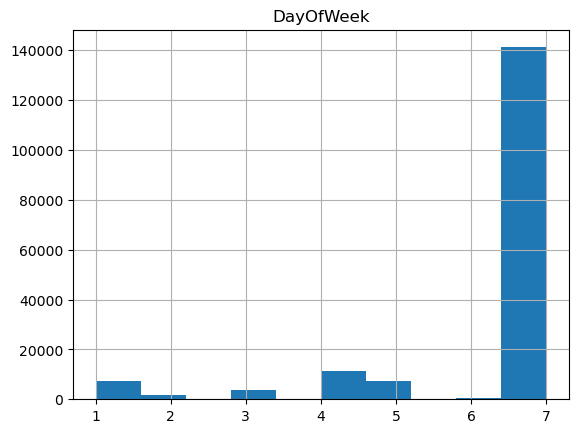

In [10]:
train_store_closed.hist('DayOfWeek')

<Axes: >

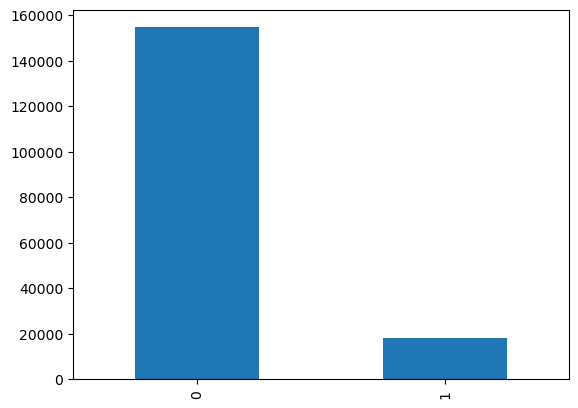

In [11]:
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar')

<Axes: >

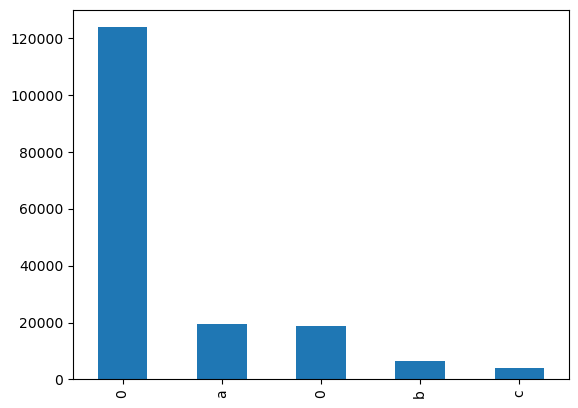

In [12]:
train_store_closed['StateHoliday'].value_counts().plot(kind='bar')

In [13]:
# Check the null values
# In here there is no null value 
train.isnull().sum()

Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
WeekofYear               0
SalesPerCustomer    172869
dtype: int64

In [14]:
train[(train.Open == 0)].shape[0]

172817

In [15]:
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [16]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [19]:
store.fillna(0, inplace=True)

In [20]:
store.isnull().sum().sum()

0

In [21]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [22]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [23]:
test.fillna(1, inplace=True)

In [24]:
test.isnull().sum().sum()

0

In [25]:
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [27]:
train_store_joined.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)


,Customers,Sales,SalesPerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [28]:
train_store_joined[(train_store_joined.Open == 0) | (train_store_joined.Sales==0)].shape

(172871, 22)

In [29]:
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,6905,471,1,1,0,1,2013,1,...,14.660297,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017204,1115,6,4771,339,1,0,0,1,2013,1,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,4540,326,1,0,0,1,2013,1,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,4297,300,1,0,0,1,2013,1,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


<Axes: >

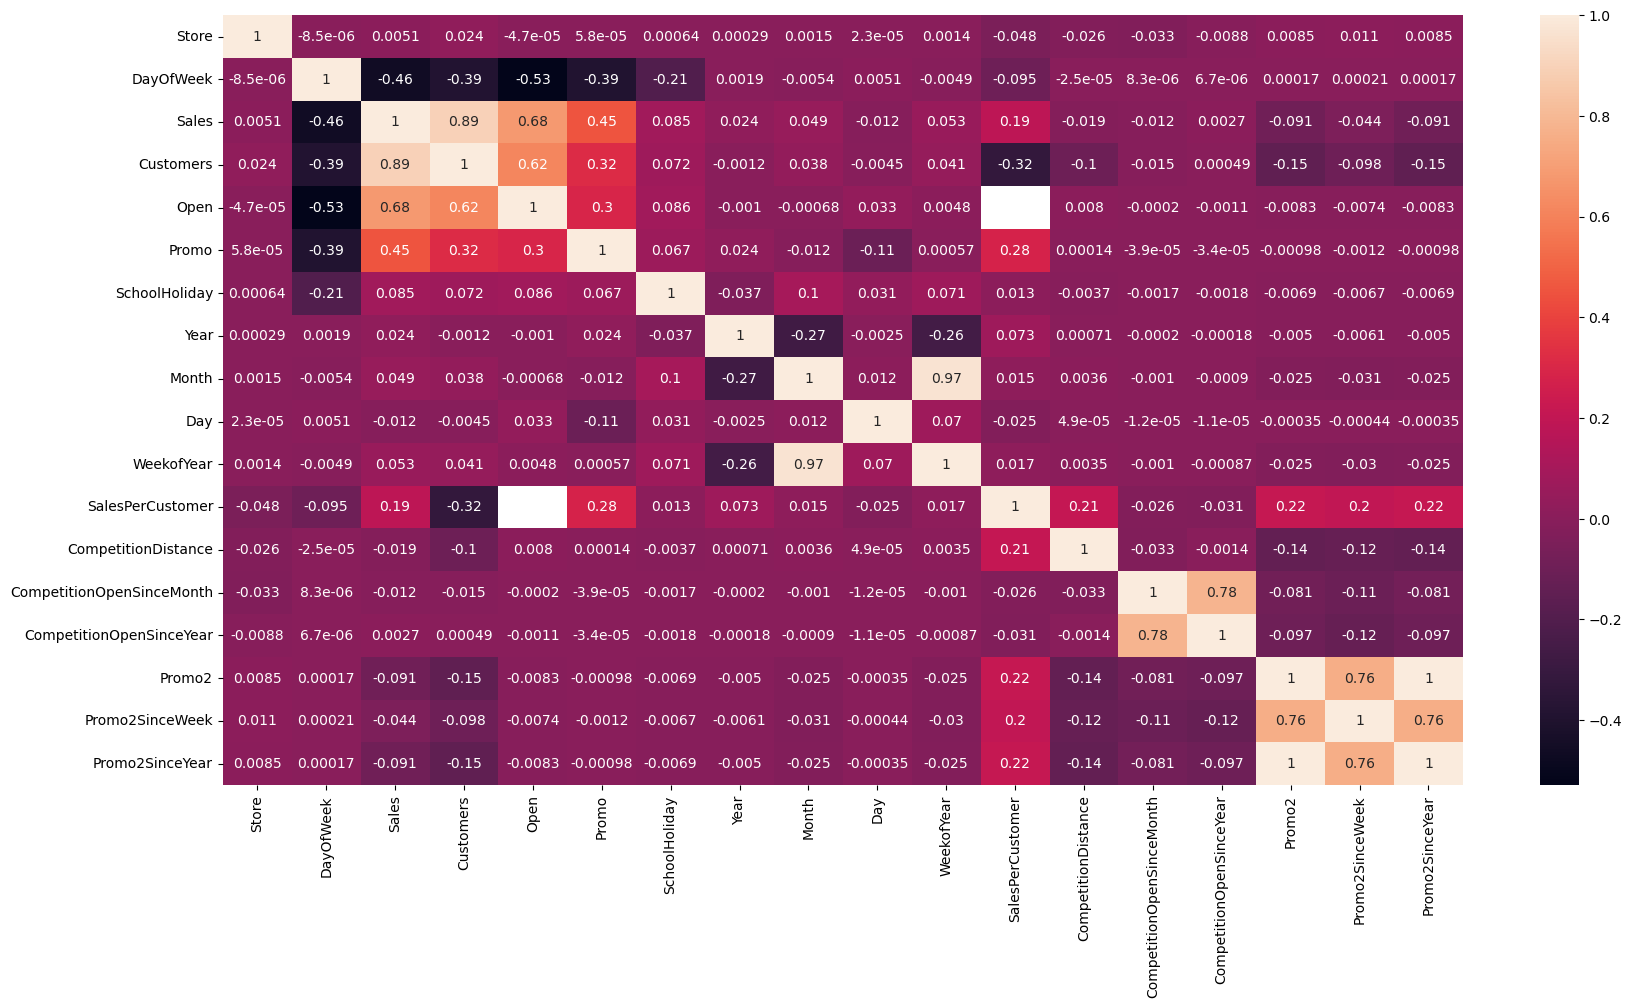

In [30]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_store_joined.corr(), annot=True)

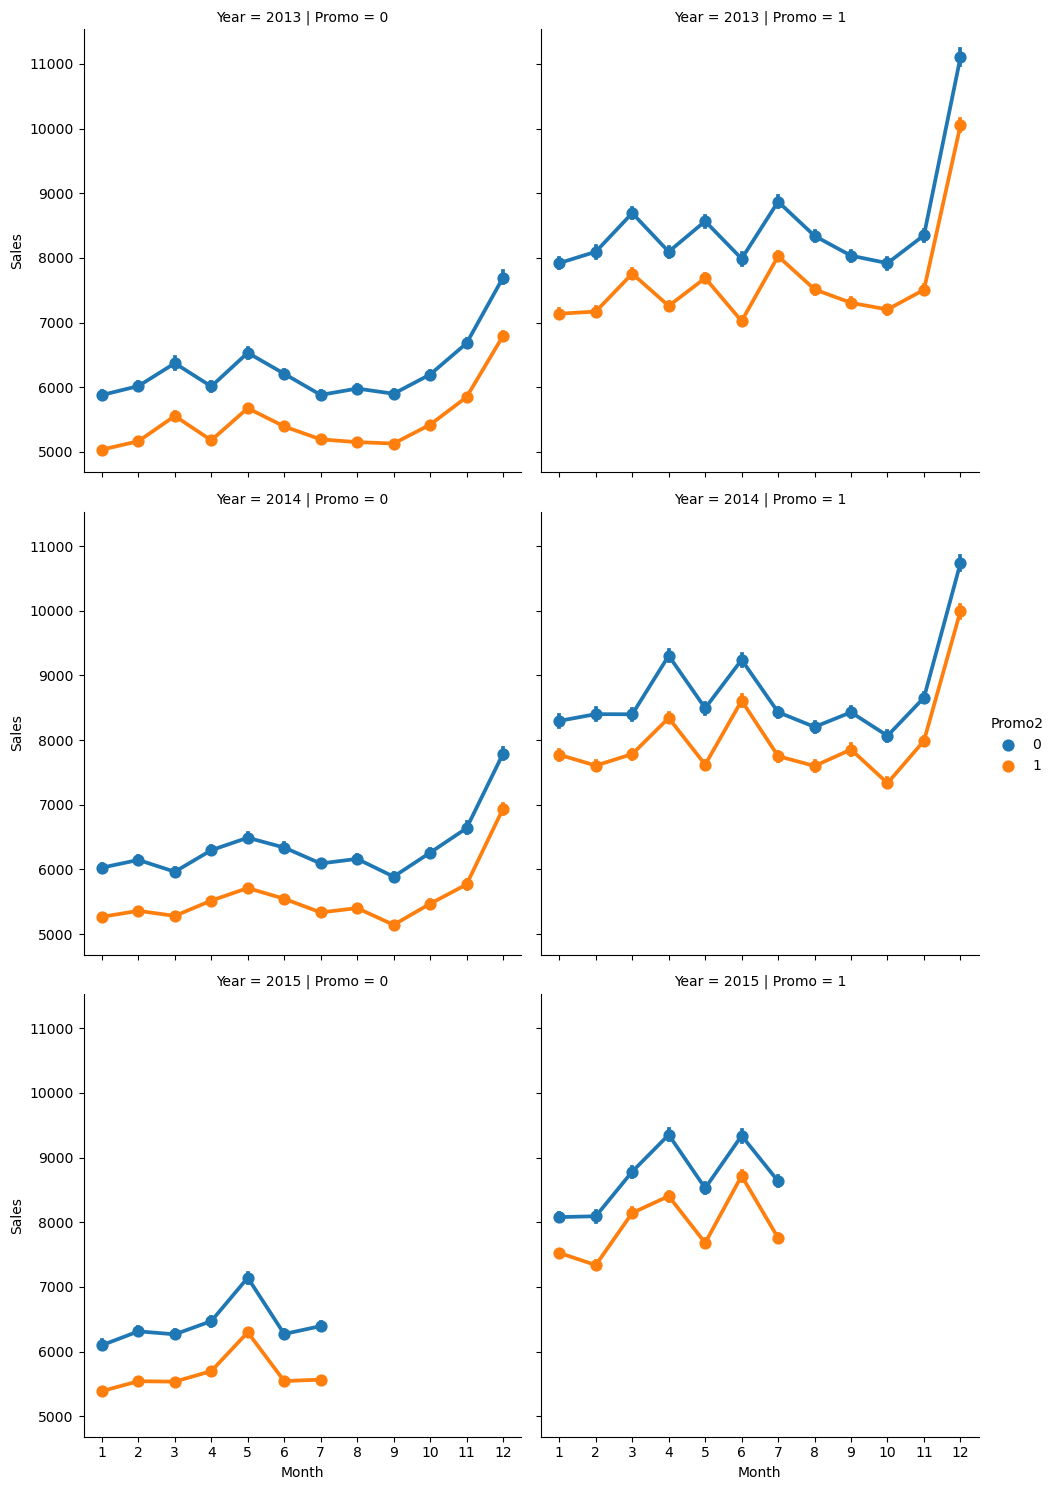

In [33]:
import seaborn as sns

sns.catplot(data=train_store_joined_open, x='Month', y='Sales',
            col='Promo', hue='Promo2', row='Year', kind='point')


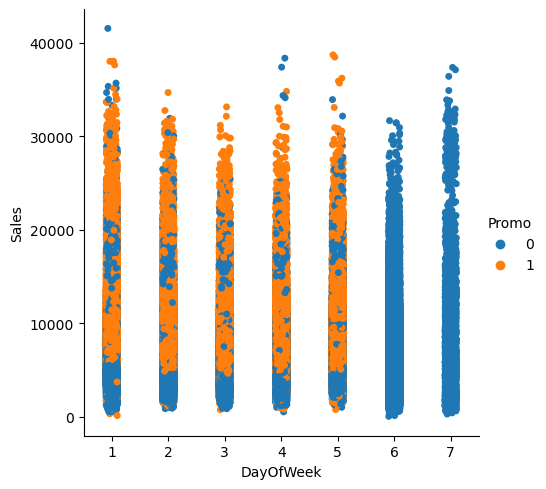

In [34]:
sns.catplot(data= train_store_joined_open, x='DayOfWeek', y="Sales",
              hue='Promo')

In [35]:
train['Sales'] = train['Sales'] * 1.00

train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [36]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

<Axes: xlabel='Date'>

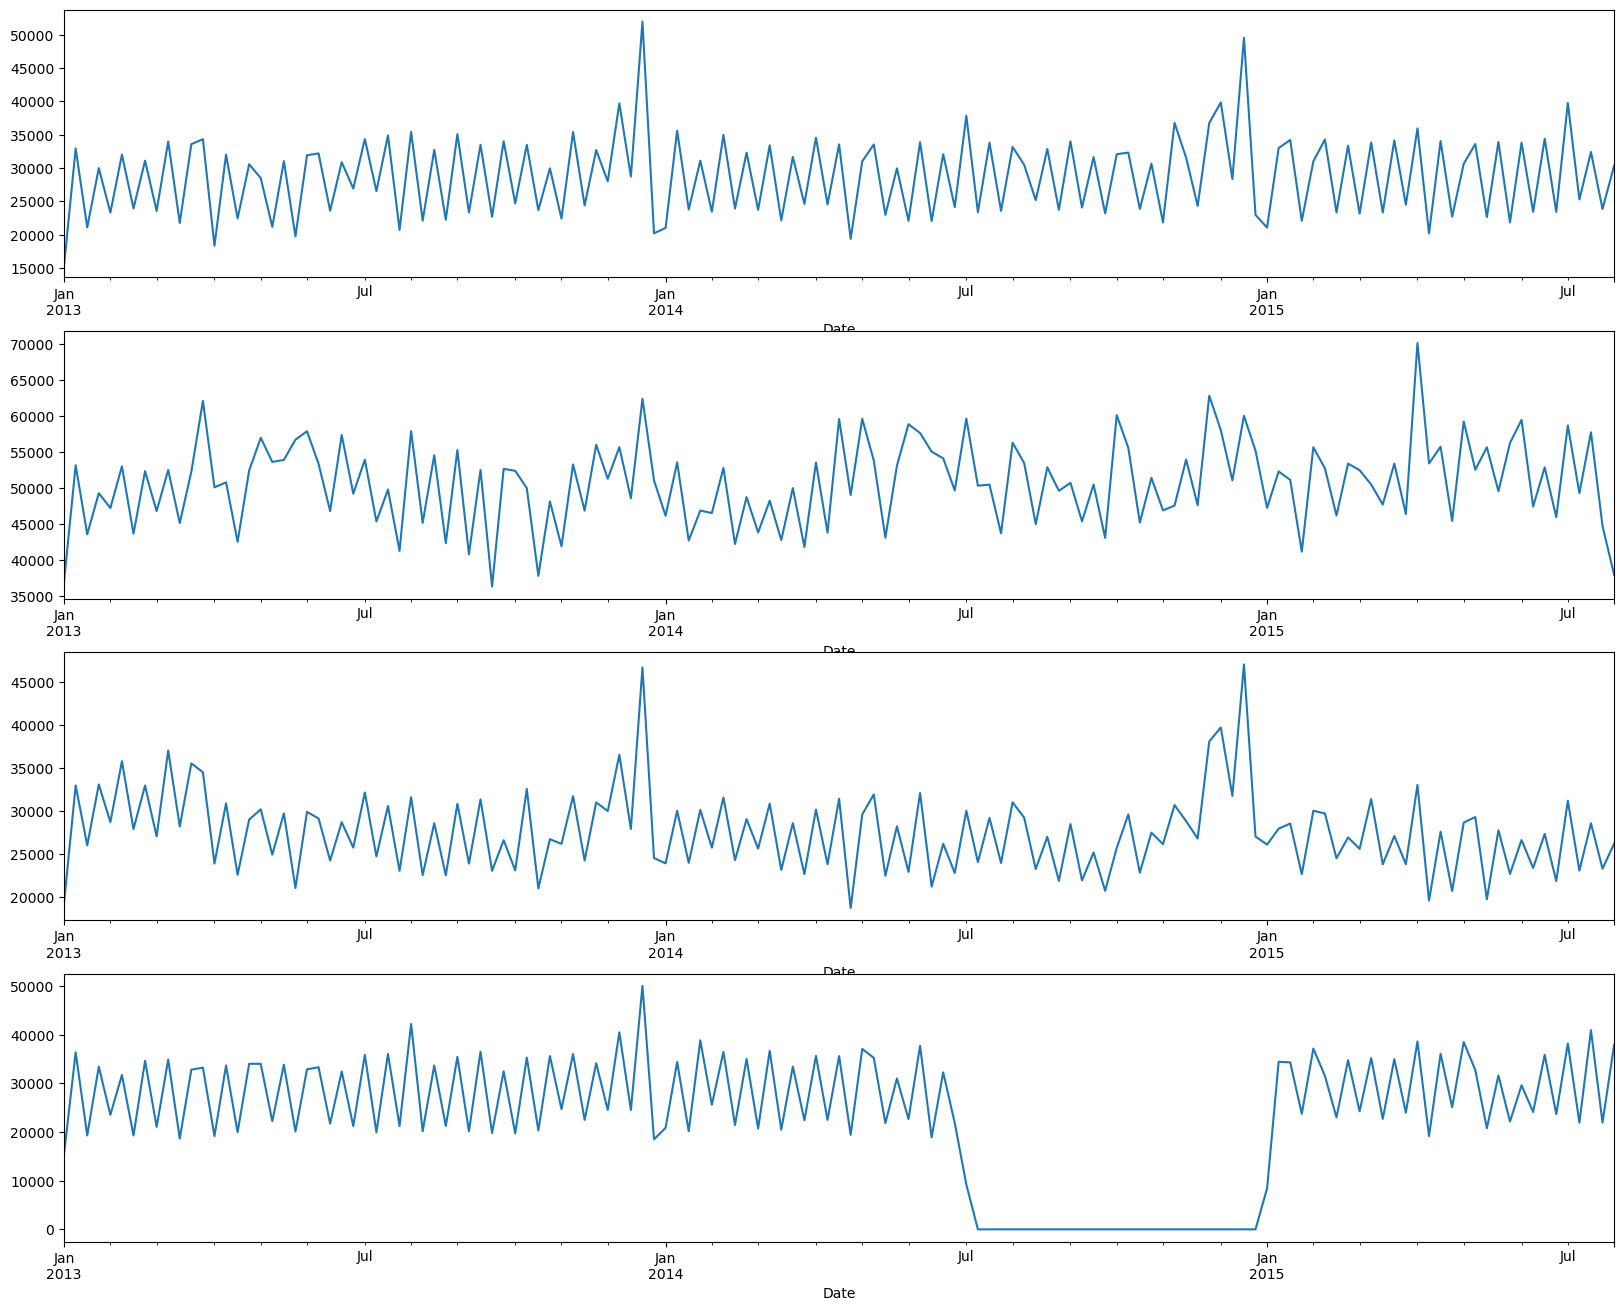

In [37]:
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))

# Visualize Trend 
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


In [39]:
def test_stationarity(timeseries):
    # Determine rolling statestics 
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    # plotting rolling statestics 
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
    plt.legend(loc='best')
    plt.show()
    
    # Performing Dickey-Fuller test 
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

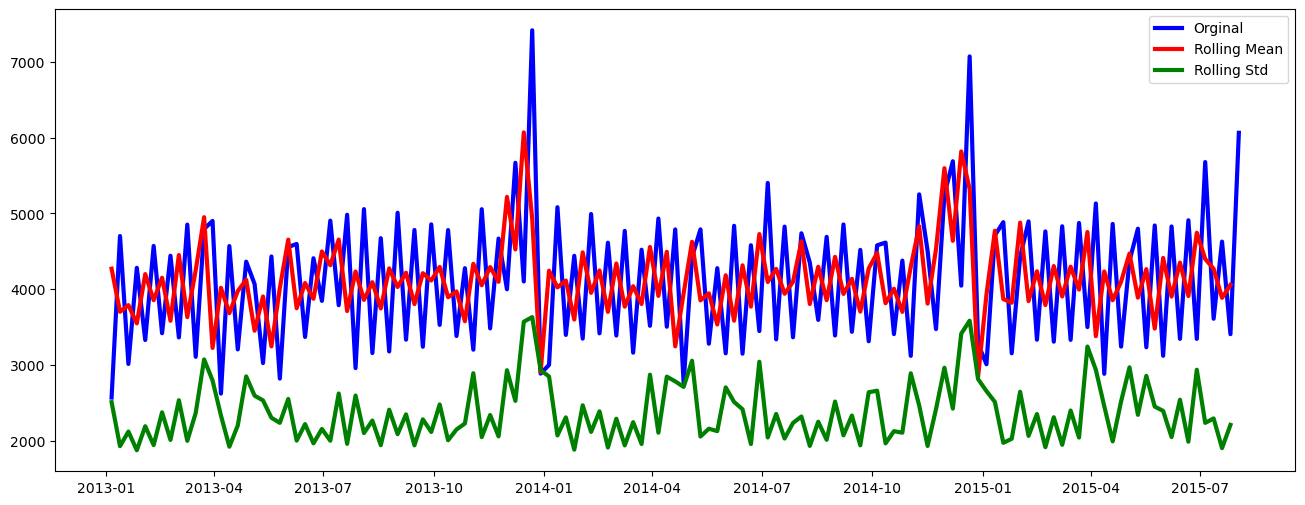

Result of Dickey-Fuller test:
ADF Statestics: -6.218237
P-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [40]:
test_stationarity(sales_a)

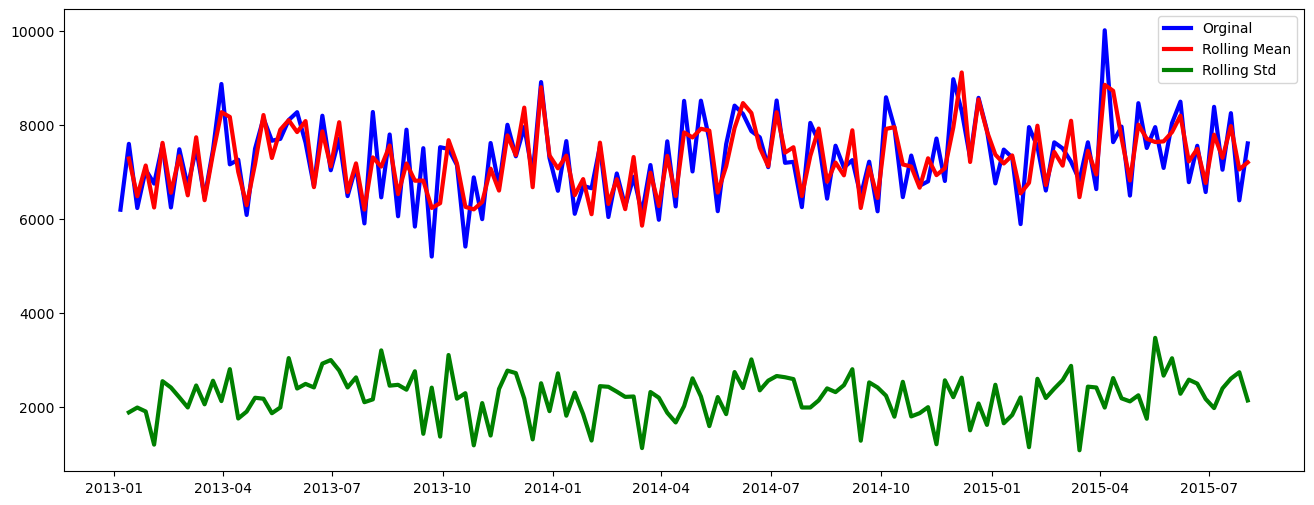

Result of Dickey-Fuller test:
ADF Statestics: -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [41]:
test_stationarity(sales_b)

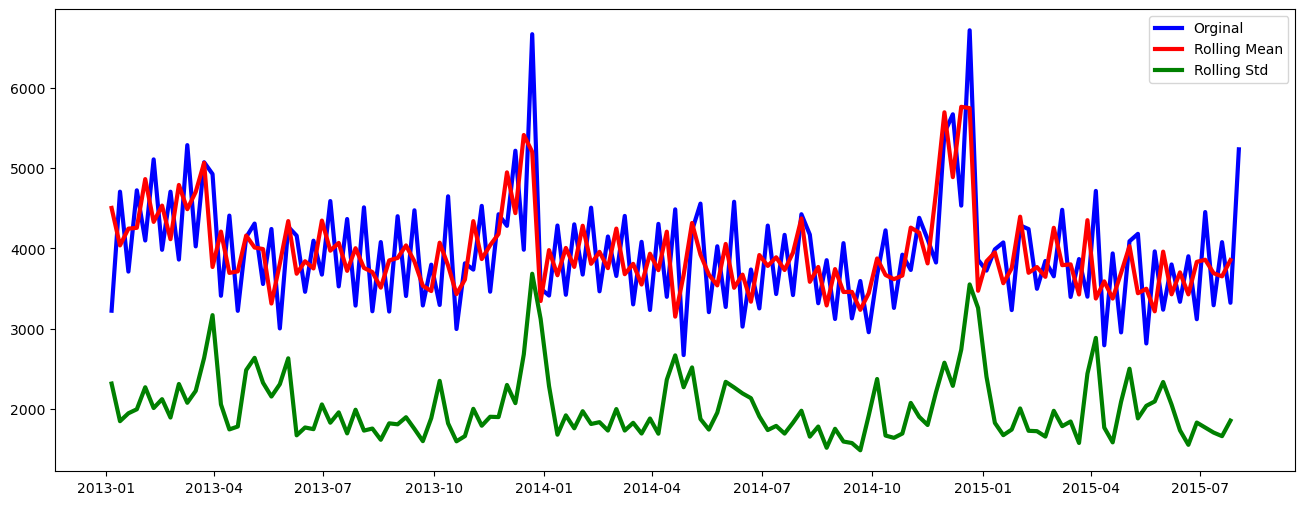

Result of Dickey-Fuller test:
ADF Statestics: -4.374784
P-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [42]:
test_stationarity(sales_c)

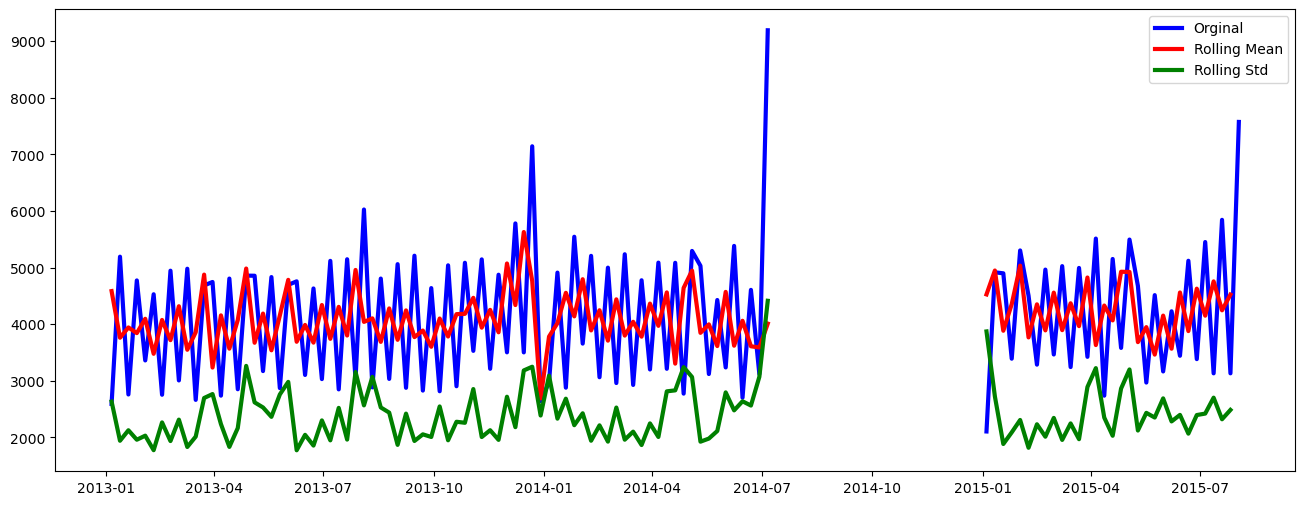

Result of Dickey-Fuller test:
ADF Statestics: -6.237461
P-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [43]:
test_stationarity(sales_d)

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def plot_timeseries(sales, StoreType):
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition = seasonal_decompose(sales, model='additive', period=365)
    
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
    ax1.plot(sales, label='Original')
    ax1.legend(loc='best')
    ax1.set_title(f'Time Series Decomposition of {StoreType}')

    ax2.plot(estimated_trend, label='Trend')
    ax2.legend(loc='best')

    ax3.plot(estimated_seasonal, label='Seasonality')
    ax3.legend(loc='best')

    ax4.plot(estimated_residual, label='Residuals')
    ax4.legend(loc='best')
    
    plt.tight_layout()
    plt.show()


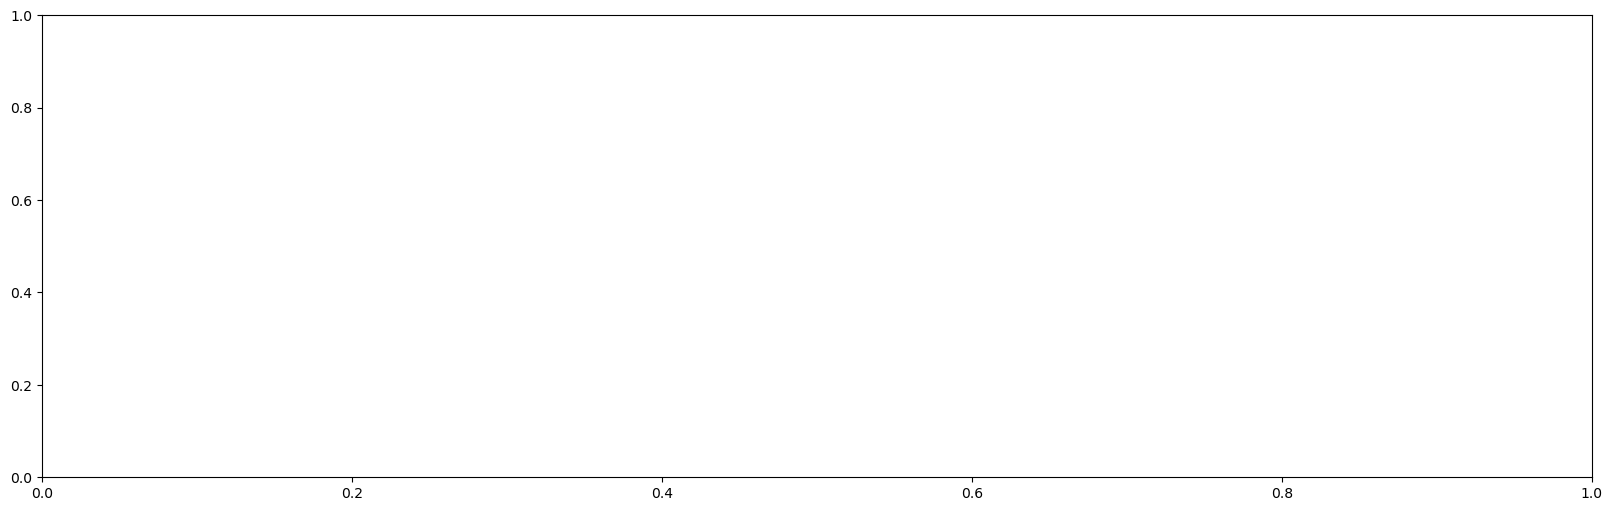

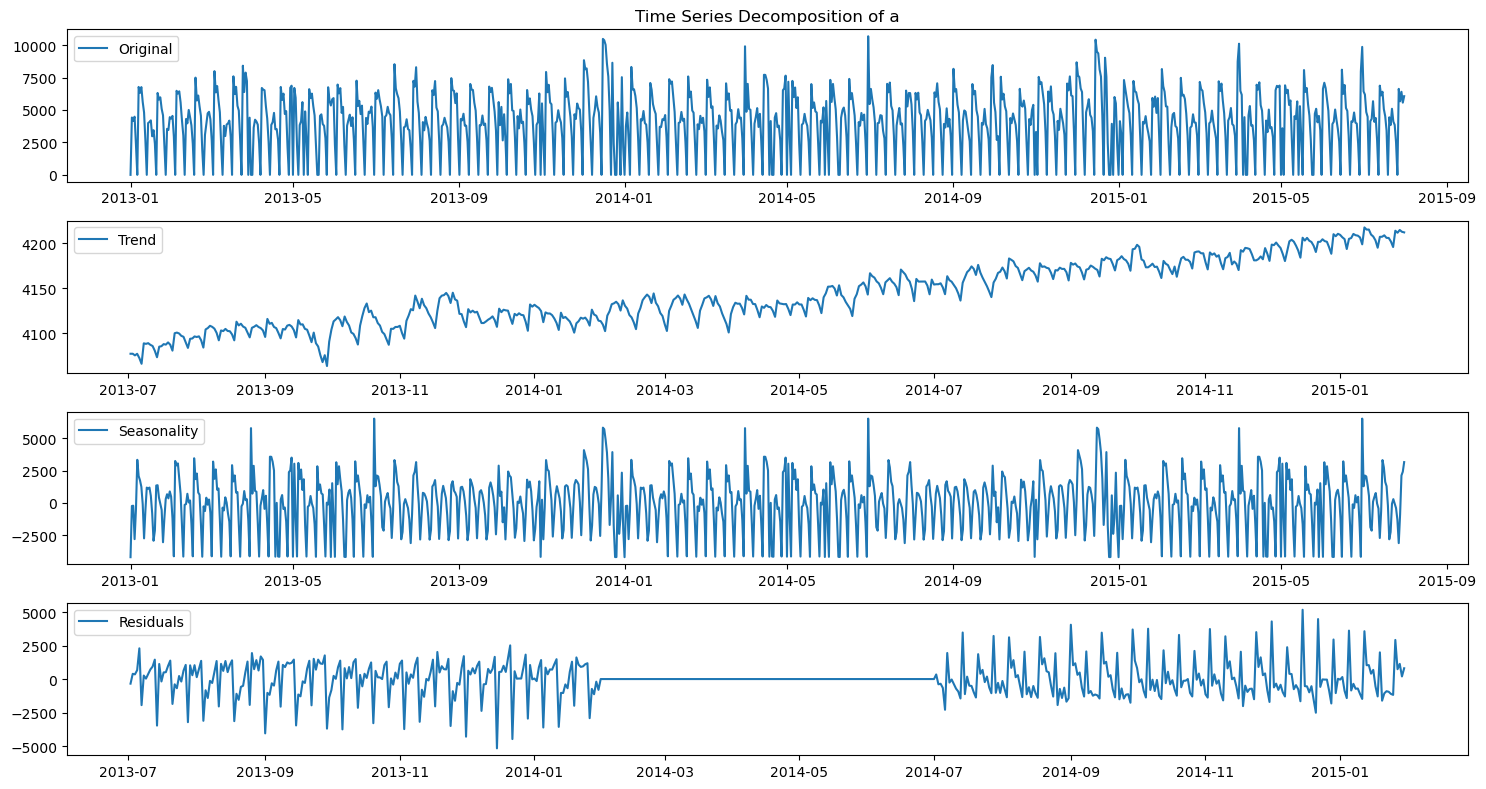

In [47]:
plot_timeseries(sales_a, 'a')

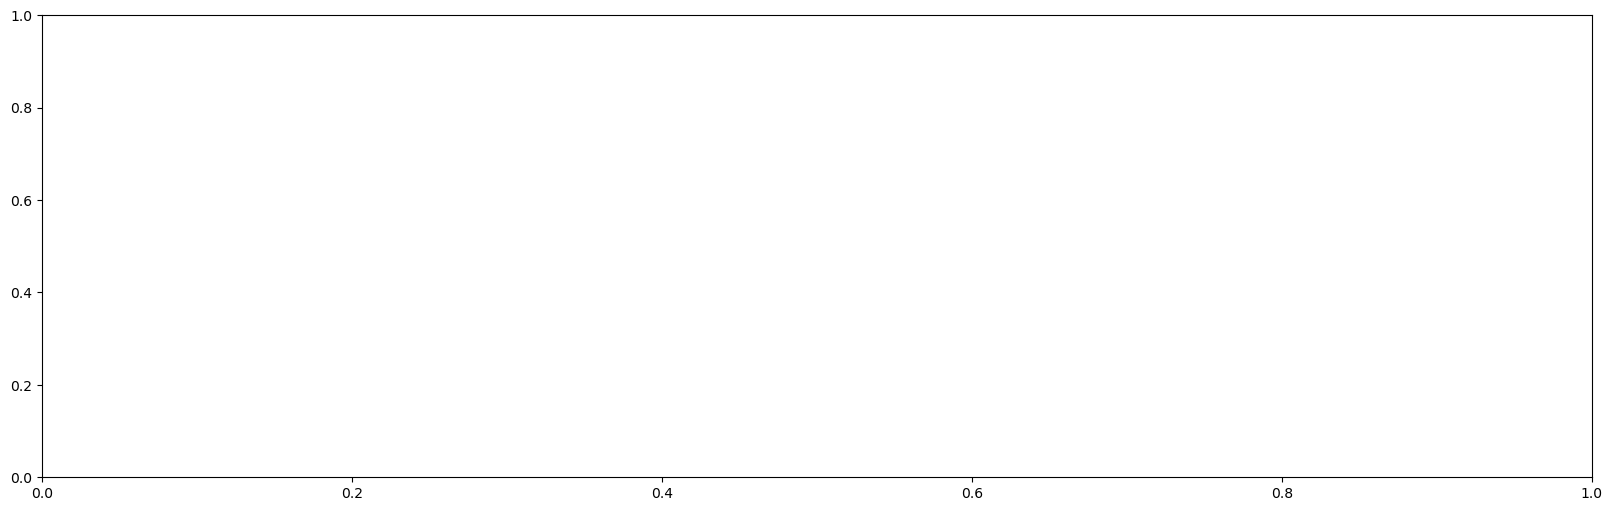

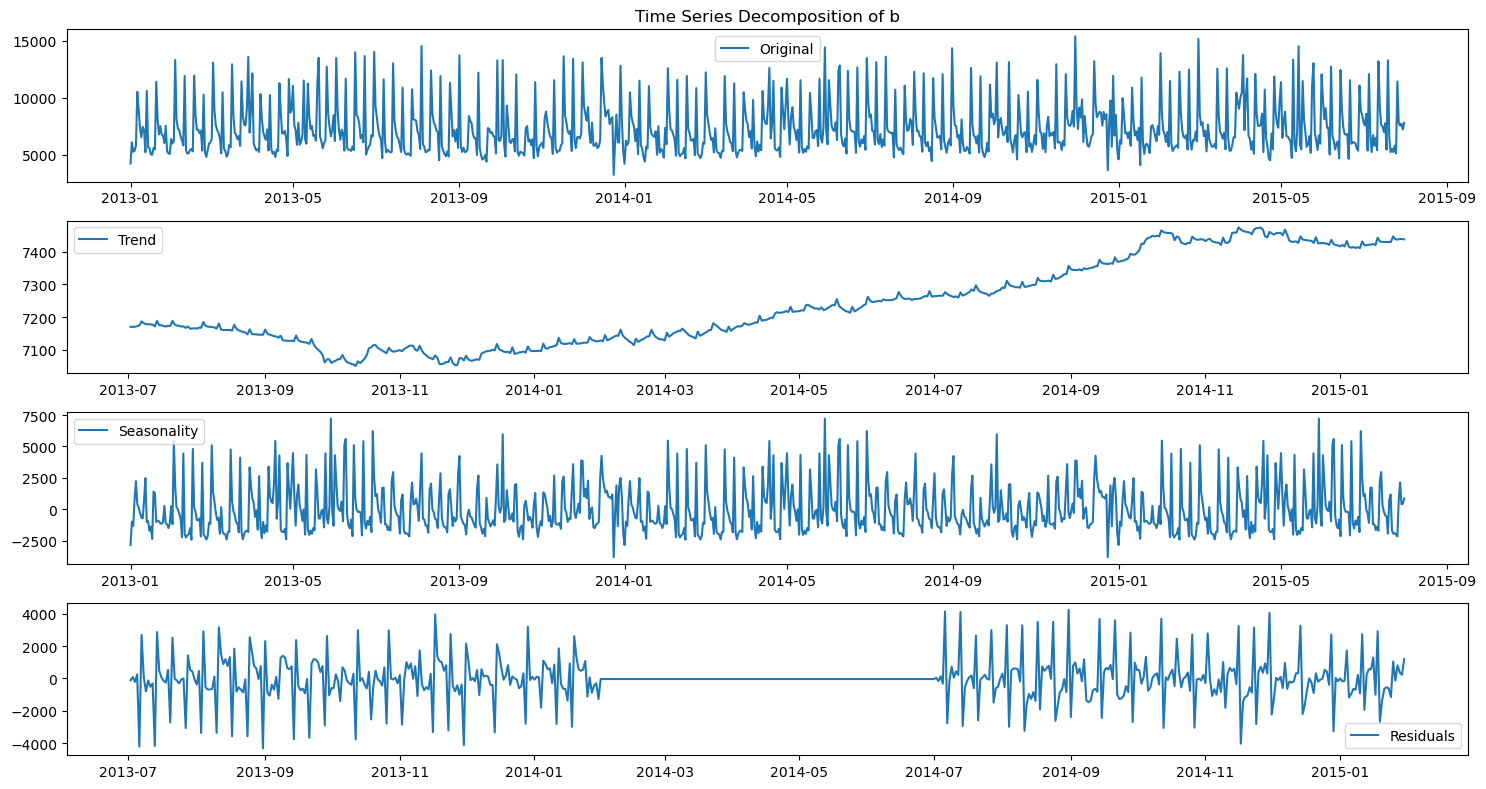

In [48]:
plot_timeseries(sales_b, 'b')

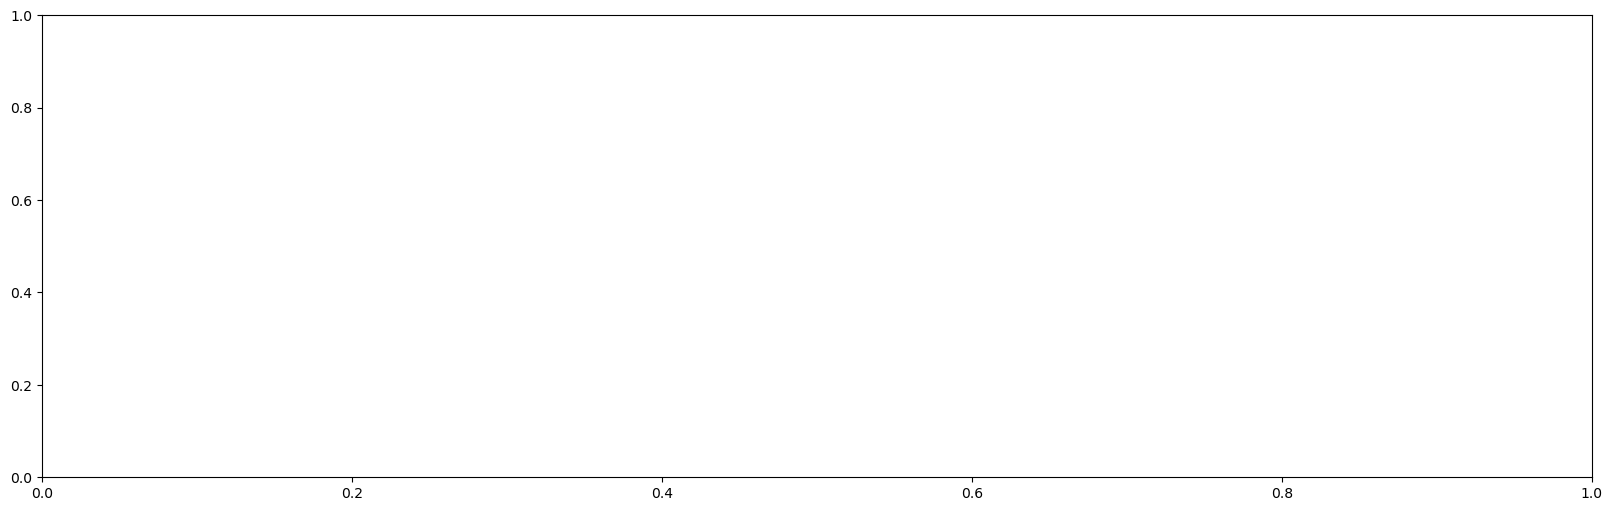

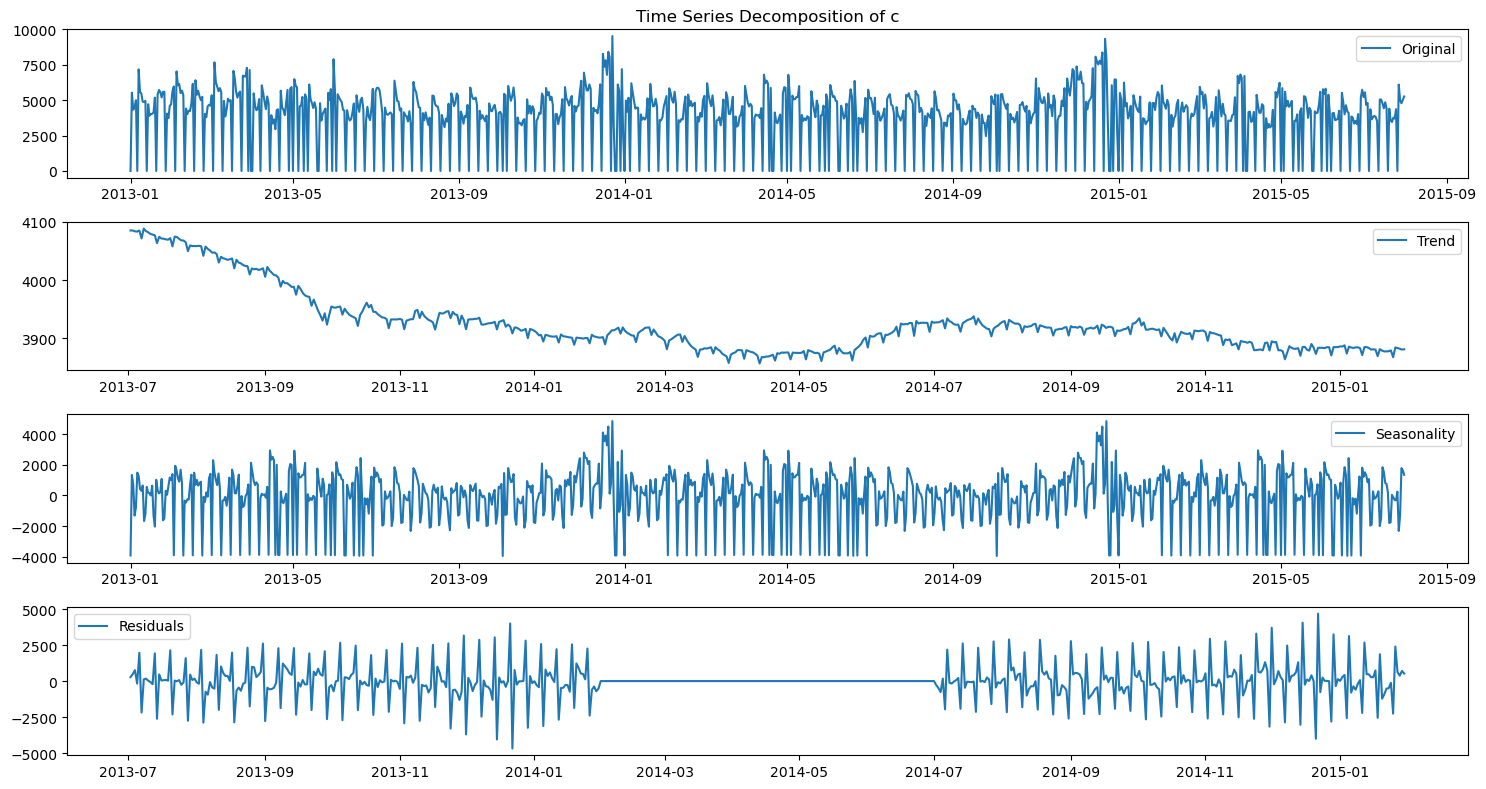

In [49]:
plot_timeseries(sales_c, 'c')

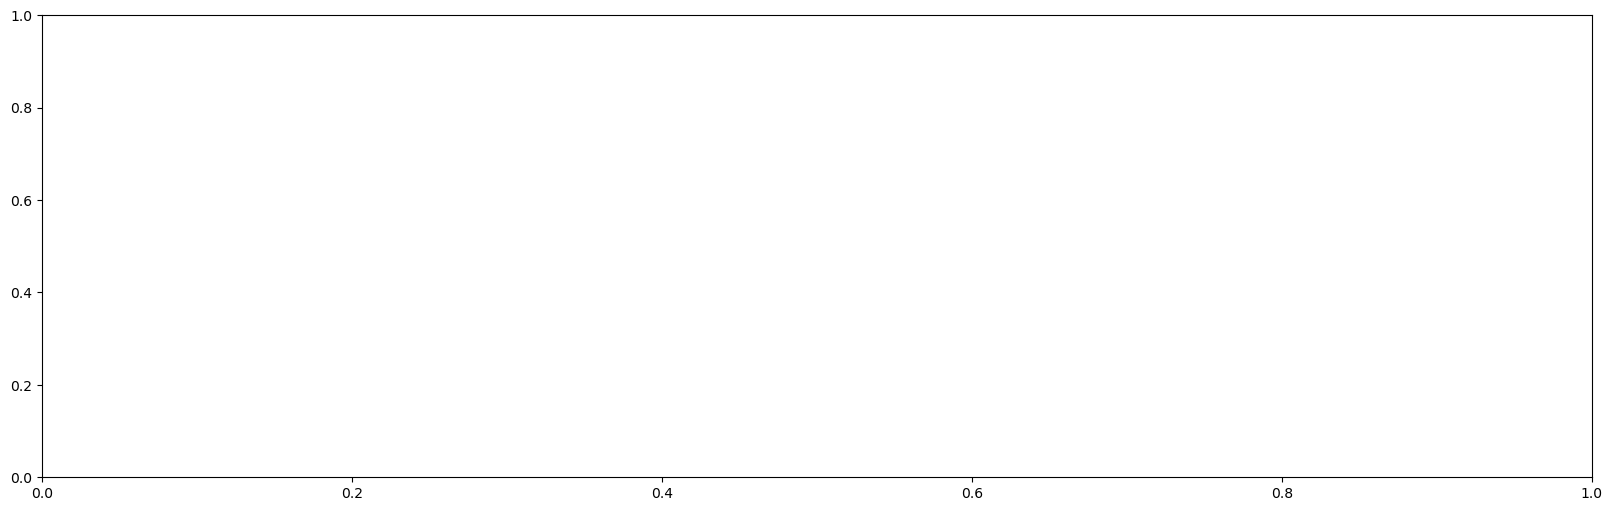

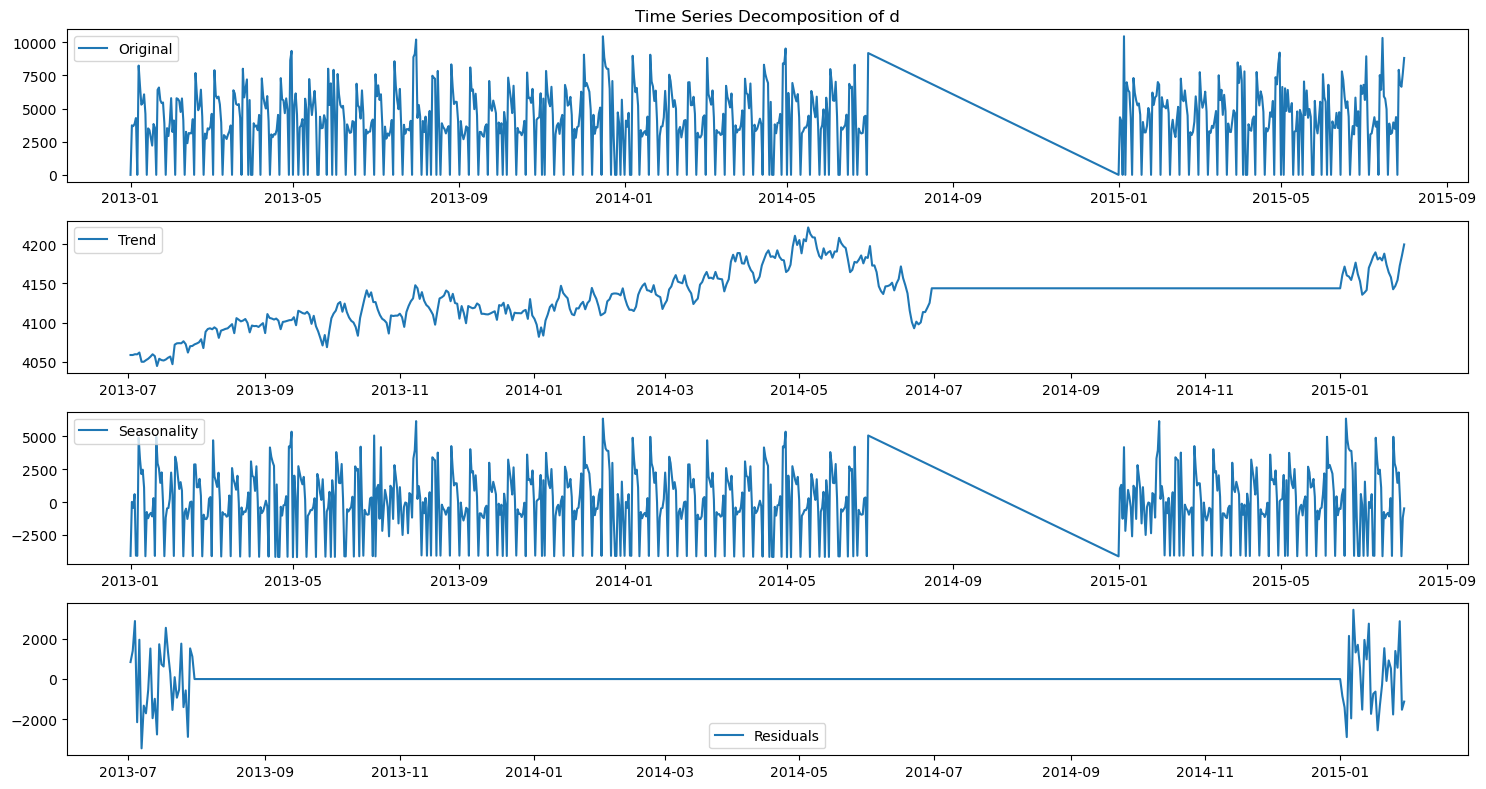

In [50]:
plot_timeseries(sales_d, 'd')

In [51]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')

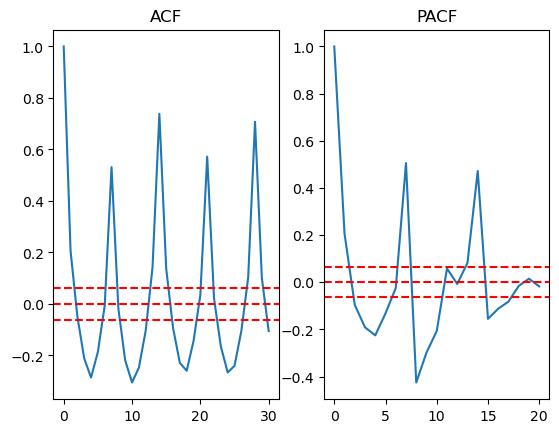

In [52]:
# ACF and PCF for store A
auto_corr(sales_a)

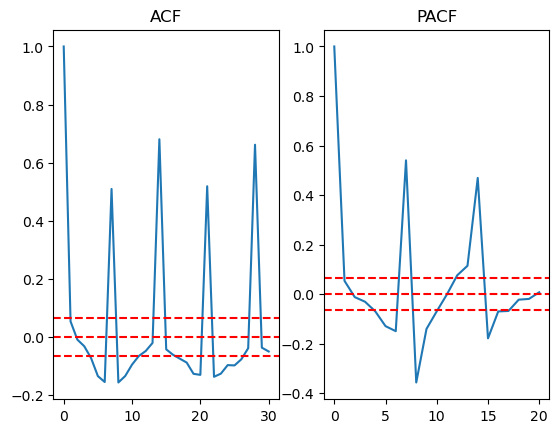

In [53]:
# ACF and PCF for store B
auto_corr(sales_b)

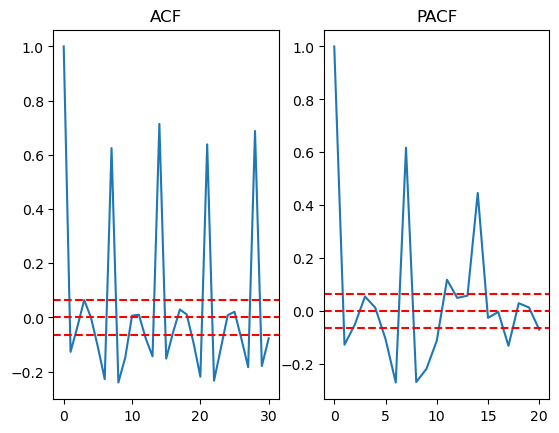

In [54]:
auto_corr(sales_c)

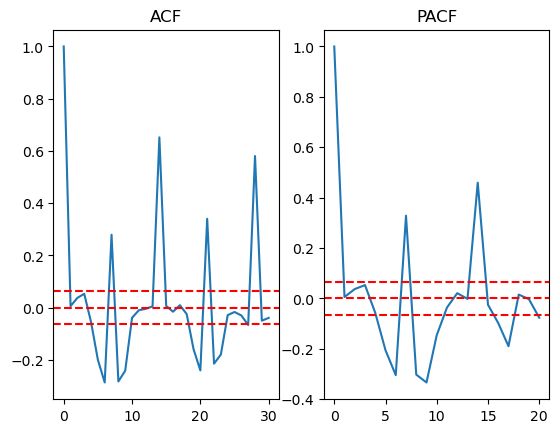

In [55]:
auto_corr(sales_d)

<Axes: xlabel='Date'>

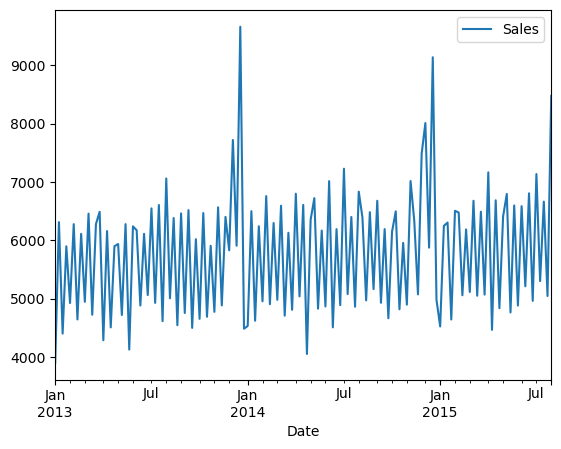

In [56]:
train_arima = train.resample('w').mean()
train_arima = train_arima[['Sales']]
train_arima.plot()

In [57]:
train_arima.head()

,Sales
Date,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960


In [58]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807691526
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.822052279851
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.7057912673386
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857757
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107370084
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.336694340702
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.886830504481
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135683
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259669916
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617135935
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908747286261
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.441508975179
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842513093
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.5804531931235


In [60]:
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.098     -5.652      0.000      -0.747      -0.362
ma.L1         -1.1418      0.055    -20.766      0.000      -1.250      -1.034
ar.S.L12      -0.1554      0.110     -1.417      0.156      -0.370       0.060
ma.S.L12      -1.0093      0.700     -1.441      0.150      -2.382       0.364
sigma2      6.236e+05   4.65e+05      1.342      0.180   -2.87e+05    1.53e+06


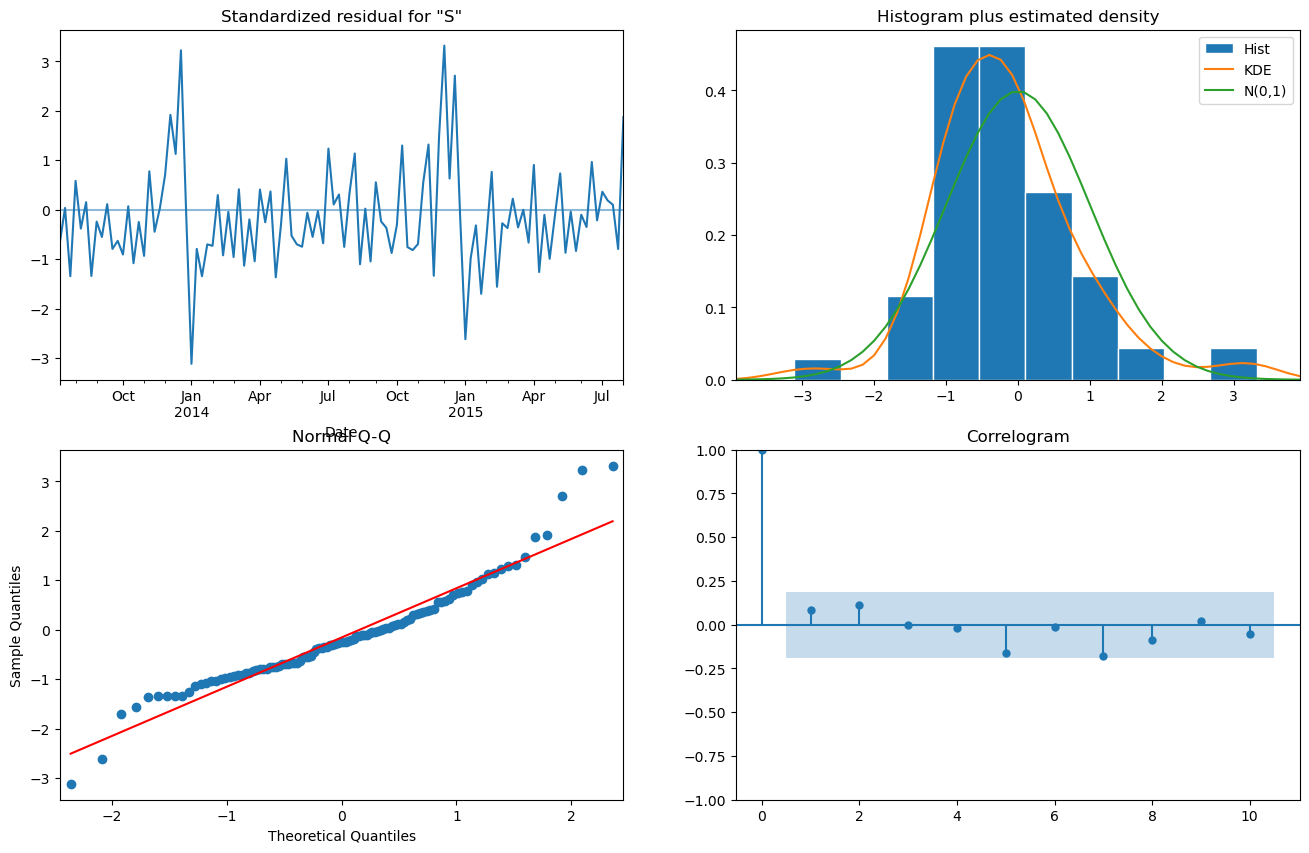

In [61]:
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

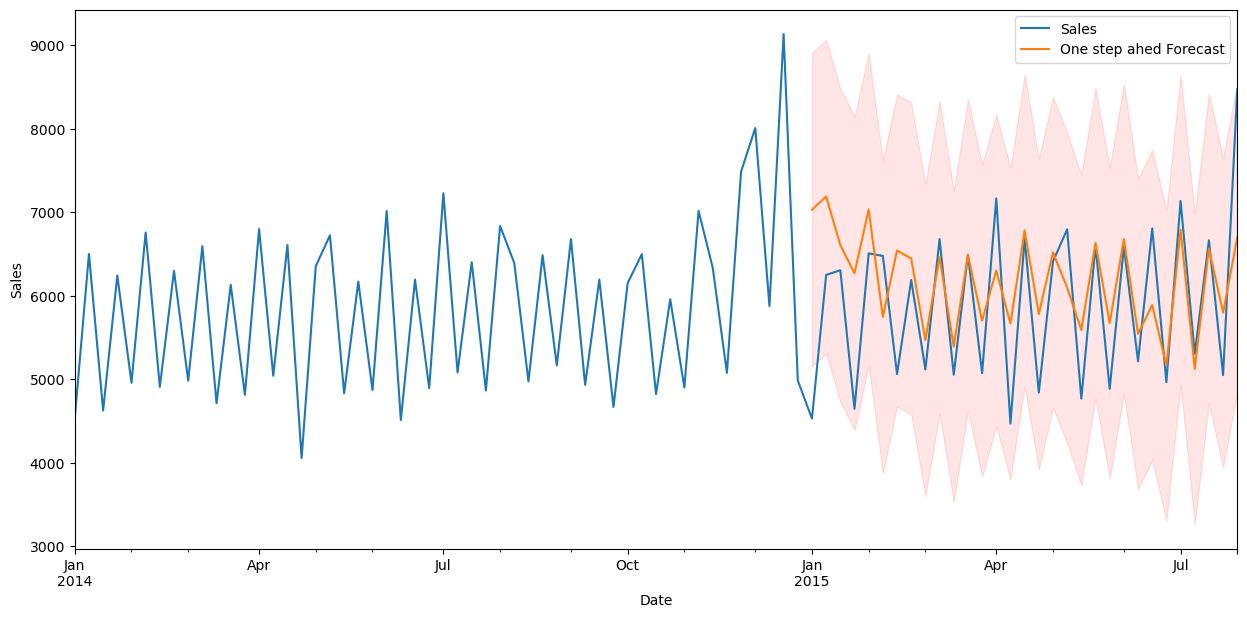

Root Mean Squared Error =  867.955232043156


In [62]:
pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast 
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [63]:
train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')

Predicted Data Saved in output


In [64]:
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [65]:
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118


In [66]:
ts_week_prophet = train_prophet.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
ds,,,,,,,,,,,,
2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533,13464957,6689,23414,6689,39406.143319
2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560,15711465,7805,78050,15610,65076.326540
2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0,15711465,7805,132685,23415,57208.229656
2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0,15711465,7805,187320,31220,65073.831993
2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128,15711465,11150,138260,39025,59686.174407


In [67]:
train_store_joined.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekofYear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [68]:
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalesPerCustomer', 'PromoInterval'], axis=1)

In [69]:
ts_xgboost.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,1,1,0,1,2015,7,31,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,1,1,0,1,2015,7,30,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,1,1,0,1,2015,7,29,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,1,1,0,1,2015,7,28,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,1,1,0,1,2015,7,27,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0


In [70]:
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekofYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [71]:
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [72]:
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

In [73]:
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[20:06:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5165.44449	eval-rmse:5157.78831
[1]	train-rmse:4013.02575	eval-rmse:4007.20672
[2]	train-rmse:3295.71504	eval-rmse:3291.57315
[3]	train-rmse:2873.03594	eval-rmse:2871.25106
[4]	train-rmse:2632.61312	eval-rmse:2631.91959
[5]	train-rmse:2496.02886	eval-rmse:2497.28181
[6]	train-rmse:2422.51482	eval-rmse:2424.61336
[7]	train-rmse:2337.30368	eval-rmse:2339.60448
[8]	train-rmse:2307.17481	eval-rmse:2309.91420
[9]	train-rmse:2289.60000	eval-rmse:2292.94840
[10]	train-rmse:2254.35150	eval-rmse:2257.98946
[11]	train-rmse:2245.30314	eval-rmse:2249.45135
[12]	train-rmse:2213.18383	eval-rmse:2217.32010
[13]	train-rmse:2169.19078	eval-rmse:2172.73520
[14]	train-rmse:2153.27941	eval-rmse:2156.47648
[15]	train-rmse:2144.51173	eval-rmse:2147.64454
[16]	train-

In [74]:
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1234.7943453959979


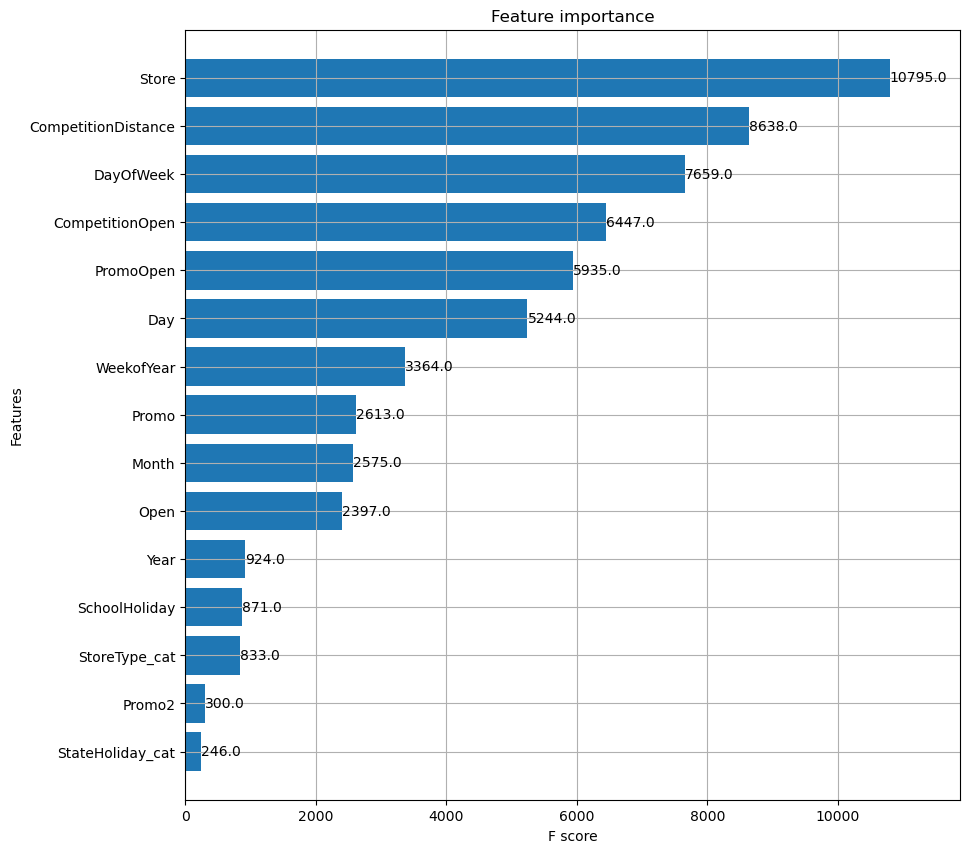

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [78]:
import pandas as pd

# Ensure that rms_arima and rms_xgboost_2 are defined
rms_arima = 1.23  # Example value, replace with your actual value
rms_xgboost_2 = 1.45  # Example value, replace with your actual value

# Convert the values to float and then format them
rms_arima = format(float(rms_arima))
rms_xgboost_2 = format(float(rms_xgboost_2))

# Create the DataFrame
model_errors = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost"],
    "RMSE": [rms_arima, rms_xgboost_2]
})

# Sort the DataFrame by RMSE
model_errors.sort_values(by="RMSE", inplace=True)

print(model_errors)


     Model  RMSE
0   SARIMA  1.23
1  XGBoost  1.45
